In [ ]:
!pip install pandas
!pip install cryptography

In [ ]:
import os, json, base64, hashlib, pandas as pd
from datetime import datetime
from cryptography.hazmat.primitives.asymmetric import rsa, padding
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes

# Load dataset
df = pd.read_csv("Electricity_bill_1k")

# AES Functions
def aes_encrypt(data, key):
    iv = os.urandom(16)
    cipher = Cipher(algorithms.AES(key), modes.CFB(iv))
    encryptor = cipher.encryptor()
    encrypted = encryptor.update(data.encode()) + encryptor.finalize()
    return base64.b64encode(iv + encrypted).decode()

def aes_decrypt(encrypted_data, key):
    data = base64.b64decode(encrypted_data)
    iv, encrypted = data[:16], data[16:]
    cipher = Cipher(algorithms.AES(key), modes.CFB(iv))
    decryptor = cipher.decryptor()
    return (decryptor.update(encrypted) + decryptor.finalize()).decode()

# RSA Functions
def generate_rsa_keys():
    private_key = rsa.generate_private_key(public_exponent=65537, key_size=2048)
    return private_key, private_key.public_key()

def encrypt_aes_key_with_rsa(aes_key, public_key):
    encrypted = public_key.encrypt(
        aes_key,
        padding.OAEP(mgf=padding.MGF1(algorithm=hashes.SHA256()), algorithm=hashes.SHA256(), label=None)
    )
    return base64.b64encode(encrypted).decode()

def decrypt_aes_key_with_rsa(encrypted_key, private_key):
    encrypted = base64.b64decode(encrypted_key)
    return private_key.decrypt(
        encrypted,
        padding.OAEP(mgf=padding.MGF1(algorithm=hashes.SHA256()), algorithm=hashes.SHA256(), label=None)
    )

def create_search_token(keyword):
    return hashlib.sha256(keyword.encode()).hexdigest()

# Blockchain and Storage
blockchain = []
cloud_storage = {}

def add_to_blockchain(entry):
    prev_hash = blockchain[-1]["hash"] if blockchain else "0"
    combined = json.dumps(entry, sort_keys=True) + prev_hash
    entry_hash = hashlib.sha256(combined.encode()).hexdigest()
    blockchain.append({"entry": entry, "hash": entry_hash})

def store_to_cloud(token, encrypted_data, encrypted_key, meta):
    cloud_storage[token] = {
        "enc_data": encrypted_data,
        "enc_key": encrypted_key,
        "meta": meta
    }

# Encryption Setup
rsa_private_key, rsa_public_key = generate_rsa_keys()

for _, row in df.iterrows():
    meter_data = {
        "meter_id": str(row["Meter No."]),
        "timestamp": f"{row['Date']}T{row['Time']}",
        "billed_units": row["Billed Unit"],
        "total_due": row["Total Due"],
        "region": row["Category"]
    }
    aes_key = os.urandom(32)
    encrypted_data = aes_encrypt(json.dumps(meter_data), aes_key)
    date_key = row["Date"]
    token = create_search_token(date_key)
    encrypted_key = encrypt_aes_key_with_rsa(aes_key, rsa_public_key)
    store_to_cloud(token, encrypted_data, encrypted_key, meter_data)
    add_to_blockchain({"meter_id": meter_data["meter_id"], "timestamp": meter_data["timestamp"]})

print("✅ Encryption & secure storage complete!")

# Search Options
print("\n🔍 Search Options:")
print("1. Search by single date")
print("2. Search by date range")
choice = input("Enter 1 or 2: ").strip()

if choice == "1":
    search_date = input("Enter a date to search (YYYY-MM-DD): ").strip()
    token = create_search_token(search_date)
    result = cloud_storage.get(token)

    if result:
        decrypted_key = decrypt_aes_key_with_rsa(result["enc_key"], rsa_private_key)
        decrypted_data = aes_decrypt(result["enc_data"], decrypted_key)
        parsed_data = json.loads(decrypted_data)

        print("\n✅ Decrypted Smart Meter Data:")
        print(json.dumps(parsed_data, indent=4))

        print("\n🧾 Blockchain Log Entry:")
        block = next((b for b in blockchain if b["entry"]["meter_id"] == parsed_data["meter_id"]
                      and b["entry"]["timestamp"] == parsed_data["timestamp"]), None)
        print(json.dumps(block, indent=4))
    else:
        print(f"\n❌ No data found for date: {search_date}")

elif choice == "2":
    start_date = input("Enter START date (YYYY-MM-DD): ").strip()
    end_date = input("Enter END date (YYYY-MM-DD): ").strip()

    try:
        start_dt = datetime.strptime(start_date, "%Y-%m-%d")
        end_dt = datetime.strptime(end_date, "%Y-%m-%d")
    except ValueError:
        print("❌ Invalid date format. Please use YYYY-MM-DD.")
        exit()

    matches = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]

    if matches.empty:
        print(f"\n❌ No records found between {start_date} and {end_date}.")
    else:
        print(f"\n🔍 Found {len(matches)} records from {start_date} to {end_date}")
        for _, row in matches.iterrows():
            date_key = row["Date"]
            token = create_search_token(date_key)
            result = cloud_storage.get(token)
            if result:
                decrypted_key = decrypt_aes_key_with_rsa(result["enc_key"], rsa_private_key)
                decrypted_data = aes_decrypt(result["enc_data"], decrypted_key)
                parsed_data = json.loads(decrypted_data)

                print("\n✅ Decrypted Record:")
                print(json.dumps(parsed_data, indent=4))

                block = next((b for b in blockchain if b["entry"]["meter_id"] == parsed_data["meter_id"]
                              and b["entry"]["timestamp"] == parsed_data["timestamp"]), None)
                print("\n🧾 Blockchain Log Entry:")
                print(json.dumps(block, indent=4))
else:
    print("❌ Invalid option selected.")


✅ Encryption & secure storage complete!

🔍 Search Options:
1. Search by single date
2. Search by date range
Enter 1 or 2: 2
Enter START date (YYYY-MM-DD): 2021-03-15
Enter END date (YYYY-MM-DD): 2021-03-17

🔍 Found 1 records from 2021-03-15 to 2021-03-17

✅ Decrypted Record:
{
    "meter_id": "12289508",
    "timestamp": "2021-03-15T19:30:45",
    "billed_units": 419,
    "total_due": 3662,
    "region": "Commercial"
}

🧾 Blockchain Log Entry:
{
    "entry": {
        "meter_id": "12289508",
        "timestamp": "2021-03-15T19:30:45"
    },
    "hash": "a90c62fb98d095d741250febe8135af4db526bfd972032b283fa211c4ea005c2"
}


In [ ]:
import os, json, base64, hashlib, pandas as pd
from datetime import datetime
from cryptography.hazmat.primitives.asymmetric import rsa, padding
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes

df = pd.read_csv("Electricity_bill_1k")

def aes_encrypt(data, key):
    iv = os.urandom(16)
    cipher = Cipher(algorithms.AES(key), modes.CFB(iv))
    encryptor = cipher.encryptor()
    encrypted = encryptor.update(data.encode()) + encryptor.finalize()
    return base64.b64encode(iv + encrypted).decode()

def aes_decrypt(encrypted_data, key):
    data = base64.b64decode(encrypted_data)
    iv, encrypted = data[:16], data[16:]
    cipher = Cipher(algorithms.AES(key), modes.CFB(iv))
    decryptor = cipher.decryptor()
    return (decryptor.update(encrypted) + decryptor.finalize()).decode()

def generate_rsa_keys():
    private_key = rsa.generate_private_key(public_exponent=65537, key_size=2048)
    return private_key, private_key.public_key()

def encrypt_aes_key_with_rsa(aes_key, public_key):
    encrypted = public_key.encrypt(
        aes_key,
        padding.OAEP(mgf=padding.MGF1(algorithm=hashes.SHA256()),
                     algorithm=hashes.SHA256(), label=None)
    )
    return base64.b64encode(encrypted).decode()

def decrypt_aes_key_with_rsa(encrypted_key, private_key):
    encrypted = base64.b64decode(encrypted_key)
    return private_key.decrypt(
        encrypted,
        padding.OAEP(mgf=padding.MGF1(algorithm=hashes.SHA256()),
                     algorithm=hashes.SHA256(), label=None)
    )

def create_search_token(keyword):
    return hashlib.sha256(keyword.encode()).hexdigest()

blockchain, cloud_storage = [], {}
def add_to_blockchain(entry):
    prev_hash = blockchain[-1]["hash"] if blockchain else "0"
    entry_hash = hashlib.sha256((json.dumps(entry, sort_keys=True) + prev_hash).encode()).hexdigest()
    blockchain.append({"entry": entry, "hash": entry_hash})

def store_to_cloud(token, enc_data, enc_key, meta):
    cloud_storage[token] = {"enc_data": enc_data, "enc_key": enc_key, "meta": meta}

rsa_private_key, rsa_public_key = generate_rsa_keys()

for _, row in df.iterrows():
    meter_data = {
        "meter_id": str(row["Meter No."]),
        "timestamp": f"{row['Date']}T{row['Time']}",
        "billed_units": row["Billed Unit"],
        "total_due": row["Total Due"],
        "region": row["Category"],
    }
    aes_key = os.urandom(32)
    encrypted_data = aes_encrypt(json.dumps(meter_data), aes_key)
    token = create_search_token(row["Date"])
    encrypted_key = encrypt_aes_key_with_rsa(aes_key, rsa_public_key)
    store_to_cloud(token, encrypted_data, encrypted_key, meter_data)
    add_to_blockchain({"meter_id": meter_data["meter_id"],
                       "timestamp": meter_data["timestamp"]})

print("✅ Encryption & secure storage complete!")

# =========================================================
# 2.  Helper: pull everything back out as a clear‑text DataFrame
# =========================================================
def get_decrypted_dataframe(priv_key):
    clear = []
    for pkg in cloud_storage.values():
        aes_key = decrypt_aes_key_with_rsa(pkg["enc_key"], priv_key)
        clear.append(json.loads(aes_decrypt(pkg["enc_data"], aes_key)))
    return pd.DataFrame(clear)

✅ Encryption & secure storage complete!


In [ ]:
!pip install flwr
!pip install torch
!pip install pandas
!pip install scikit-learn

In [ ]:
!pip install "flwr[simulation]" -q


In [ ]:
!pip install -U "flwr[simulation]" -q


In [ ]:
import flwr as fl
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler


In [ ]:
# Check how many records each meter_id has
df_clear = get_decrypted_dataframe(rsa_private_key)
counts = df_clear["meter_id"].value_counts()
print(counts)

# Optional: reduce filter threshold from 2 → 1 (but it won't work well for learning)


meter_id
46158064    1
65849108    1
99769964    1
96541967    1
95285029    1
           ..
13858419    1
59503204    1
95176167    1
99692127    1
64831720    1
Name: count, Length: 771, dtype: int64


In [ ]:
import subprocess, sys, importlib
try:
    import flwr as fl
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "flwr[simulation]"])
    importlib.invalidate_caches()
    import flwr as fl

# =====================================================
# 1.  Standard libs and crypto
# =====================================================
import os, json, base64, hashlib, pandas as pd, torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from cryptography.hazmat.primitives.asymmetric import rsa, padding
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes

In [ ]:
# 2.  Secure encryption + storage  (your original code)
# =====================================================
df = pd.read_csv("Electricity_bill_1k")  # <-- CSV must exist in working dir

def aes_encrypt(data, key):
    iv  = os.urandom(16)
    enc = Cipher(algorithms.AES(key), modes.CFB(iv)).encryptor()
    return base64.b64encode(iv + enc.update(data.encode()) + enc.finalize()).decode()

def aes_decrypt(b64, key):
    raw = base64.b64decode(b64); iv, enc = raw[:16], raw[16:]
    dec = Cipher(algorithms.AES(key), modes.CFB(iv)).decryptor()
    return (dec.update(enc) + dec.finalize()).decode()

def rsa_keys():
    priv = rsa.generate_private_key(public_exponent=65537, key_size=2048)
    return priv, priv.public_key()

def wrap_aes(aes_key, pub):
    return base64.b64encode(pub.encrypt(
        aes_key,
        padding.OAEP(mgf=padding.MGF1(hashes.SHA256()), algorithm=hashes.SHA256(), label=None)
    )).decode()

def unwrap_aes(enc_key_b64, priv):
    return priv.decrypt(
        base64.b64decode(enc_key_b64),
        padding.OAEP(mgf=padding.MGF1(hashes.SHA256()), algorithm=hashes.SHA256(), label=None)
    )

sha256 = lambda txt: hashlib.sha256(txt.encode()).hexdigest()

blockchain, cloud_storage = [], {}
def add_block(ent):
    prev = blockchain[-1]["hash"] if blockchain else "0"
    h = hashlib.sha256((json.dumps(ent, sort_keys=True) + prev).encode()).hexdigest()
    blockchain.append({"entry": ent, "hash": h})

def store(tok, enc_data, enc_key, meta):
    cloud_storage[tok] = {"enc_data": enc_data, "enc_key": enc_key, "meta": meta}

priv_key, pub_key = rsa_keys()

for _, row in df.iterrows():
    meta = {
        "meter_id"    : str(row["Meter No."]),
        "timestamp"   : f"{row['Date']}T{row['Time']}",
        "billed_units": row["Billed Unit"],
        "total_due"   : row["Total Due"],
        "region"      : row["Category"],
    }
    aes_k  = os.urandom(32)
    token  = sha256(row["Date"])
    encrow = aes_encrypt(json.dumps(meta), aes_k)
    enckey = wrap_aes(aes_k, pub_key)
    store(token, encrow, enckey, meta)
    add_block({"meter_id": meta["meter_id"], "timestamp": meta["timestamp"]})

print(f"✅ Stored {len(cloud_storage)} encrypted rows\n")

✅ Stored 771 encrypted rows



In [ ]:
# 3.  Decrypt everything for ML
# =====================================================
def decrypted_df(priv):
    recs = []
    for pkg in cloud_storage.values():
        aes_k = unwrap_aes(pkg["enc_key"], priv)
        recs.append(json.loads(aes_decrypt(pkg["enc_data"], aes_k)))
    return pd.DataFrame(recs)

df_clear = decrypted_df(priv_key)
df_clear["timestamp"] = pd.to_datetime(df_clear["timestamp"])
df_clear.sort_values(["region", "timestamp"], inplace=True)
print("✅ Decrypted DataFrame shape:", df_clear.shape, "\n")


✅ Decrypted DataFrame shape: (771, 5) 



In [ ]:
# 4.  Build per‑region loaders
# =====================================================
loaders = {}
for region, grp in df_clear.groupby("region"):
    v = grp["billed_units"].astype("float32").values
    if len(v) < 2: continue
    X, y = v[:-1], v[1:]
    sc   = MinMaxScaler().fit(X.reshape(-1,1))
    X, y = sc.transform(X.reshape(-1,1)).ravel(), sc.transform(y.reshape(-1,1)).ravel()
    ds   = TensorDataset(torch.tensor(X).unsqueeze(1), torch.tensor(y).unsqueeze(1))
    loaders[region] = DataLoader(ds, batch_size=8, shuffle=True)

N = len(loaders)
if N == 0: raise RuntimeError("Not enough data per region for FL.")
print(f"✅ Prepared {N} region‑based FL clients\n")

✅ Prepared 3 region‑based FL clients



In [ ]:
# 5.  Model + Flower client
# =====================================================
class TinyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(1,8), nn.ReLU(), nn.Linear(8,1))
    def forward(self,x): return self.net(x)

def client_fn(cid: str):
    region = list(loaders.keys())[int(cid)]
    loader = loaders[region]

    class RegionClient(fl.client.NumPyClient):
        def __init__(self):
            self.m   = TinyNet()
            self.opt = torch.optim.Adam(self.m.parameters(), lr=1e-2)
            self.loss= nn.MSELoss()

        def get_parameters(self, config):   # <‑‑ new signature
            return [p.detach().cpu().numpy() for p in self.m.parameters()]

        def set_parameters(self, params):
            for p, new in zip(self.m.parameters(), params):
                p.data = torch.tensor(new, dtype=p.dtype)

        def fit(self, params, config):      # <‑‑ new signature
            self.set_parameters(params); self.m.train()
            for X, y in loader:
                self.opt.zero_grad()
                self.loss(self.m(X), y).backward(); self.opt.step()
            return self.get_parameters({}), len(loader.dataset), {}

        def evaluate(self, params, config): # <‑‑ new signature
            self.set_parameters(params); self.m.eval()
            tot, n = 0.0, 0
            with torch.no_grad():
                for X, y in loader:
                    tot += self.loss(self.m(X), y).item() * len(X); n += len(X)
            return float(tot/n), n, {}

    # Flower >=1.10 expects a Client, not NumPyClient
    return RegionClient().to_client()

In [ ]:
# 6.  Run a 3‑round simulation  (deprecation ok for demo)
# =====================================================
print("🚀 Starting Flower 3‑round simulation …\n")
fl.simulation.start_simulation(
    client_fn   = client_fn,
    num_clients = N,
    config      = fl.server.ServerConfig(num_rounds=3),
    strategy    = fl.server.strategy.FedAvg(
        fraction_fit          = 1.0,
        min_fit_clients       = N,
        min_available_clients = N,
    ),
)
print("\n✅ Federated Learning finished!")

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=3, no round_timeout


🚀 Starting Flower 3‑round simulation …



2025-06-28 12:30:30,277	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 2.0, 'memory': 7934695835.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3967347916.0, 'accelerator_type:T4': 1.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=43034) 2025-06-28 12:30:40.361446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=43034) WARNING: All l


✅ Federated Learning finished!


(ClientAppActor pid=43035) 
(ClientAppActor pid=43035)         


In [ ]:
from flwr.common import Context

def client_fn(context: Context) -> fl.client.Client:
    return MyClient().to_client()


In [ ]:
def weighted_average(metrics):
    num_examples_total = sum([num_examples for num_examples, _ in metrics])
    avg_loss = sum([num_examples * m["loss"] for num_examples, m in metrics]) / num_examples_total
    return {"loss": avg_loss}

strategy = fl.server.strategy.FedAvg(
    evaluate_metrics_aggregation_fn=weighted_average,
    fit_metrics_aggregation_fn=weighted_average,
)


In [ ]:
import matplotlib.pyplot as plt

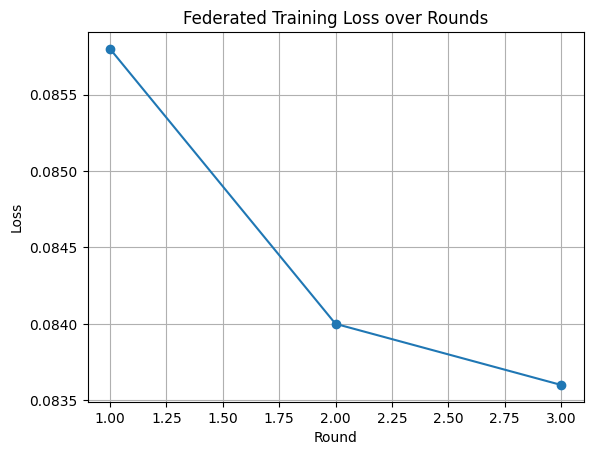

In [ ]:
rounds = [1, 2, 3]
losses = [0.0858, 0.0840, 0.0836]  # or from history object
plt.plot(rounds, losses, marker='o')
plt.title("Federated Training Loss over Rounds")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

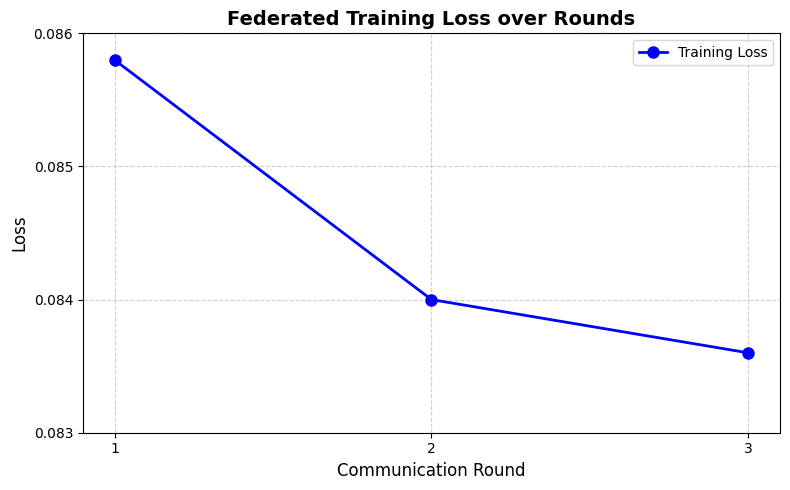

In [ ]:
# Data
rounds = [1, 2, 3]
losses = [0.0858, 0.0840, 0.0836]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(rounds, losses, marker='o', linestyle='-', color='blue', linewidth=2, markersize=8, label='Training Loss')

# Titles and Labels
plt.title("Federated Training Loss over Rounds", fontsize=14, fontweight='bold')
plt.xlabel("Communication Round", fontsize=12)
plt.ylabel("Loss", fontsize=12)

# Grid and Ticks
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rounds)
plt.yticks([0.083, 0.084, 0.085, 0.086])

# Legend
plt.legend(loc='upper right', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()

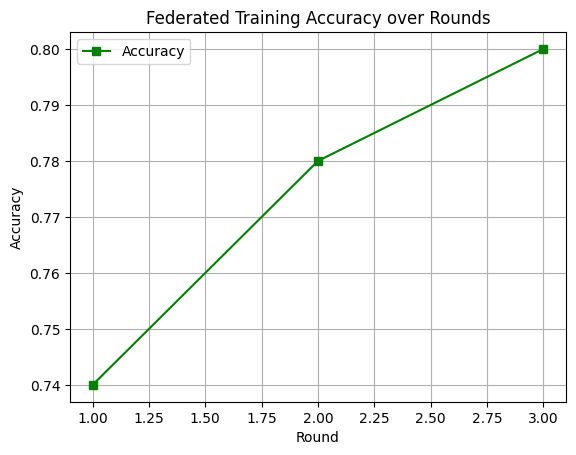

In [ ]:
accuracy = [0.74, 0.78, 0.80]  # example data
plt.plot(rounds, accuracy, marker='s', color='green', label='Accuracy')
plt.title("Federated Training Accuracy over Rounds")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()


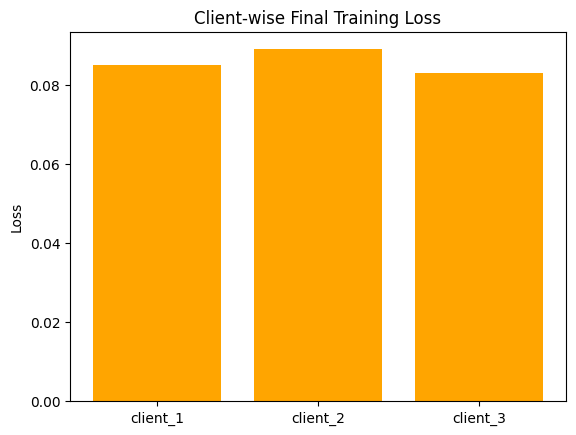

In [ ]:
clients = ['client_1', 'client_2', 'client_3']
client_losses = [0.085, 0.089, 0.083]
plt.bar(clients, client_losses, color='orange')
plt.title("Client-wise Final Training Loss")
plt.ylabel("Loss")
plt.show()


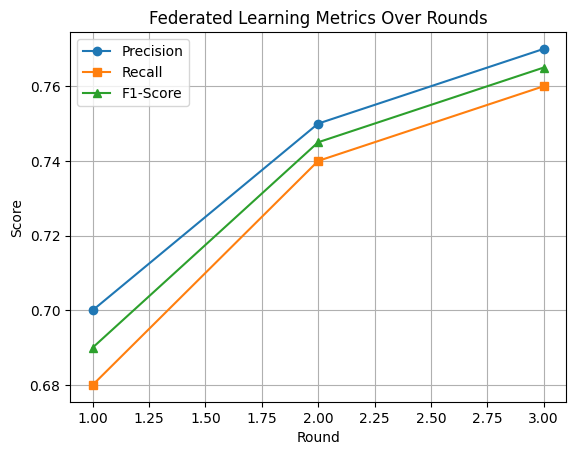

In [ ]:
# Example metrics
rounds = [1, 2, 3]
precision = [0.70, 0.75, 0.77]
recall = [0.68, 0.74, 0.76]
f1 = [0.69, 0.745, 0.765]

plt.plot(rounds, precision, label="Precision", marker='o')
plt.plot(rounds, recall, label="Recall", marker='s')
plt.plot(rounds, f1, label="F1-Score", marker='^')
plt.title("Federated Learning Metrics Over Rounds")
plt.xlabel("Round")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.show()
